Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Epoch 1/20
3355/3355 [==============================] - 72s 20ms/step - loss: 0.1807 - accuracy: 0.9571 - val_loss: 0.1817 - val_accuracy: 0.9580
Epoch 2/20
3355/3355 [==============================] - 27s 8ms/step - loss: 0.1335 - accuracy: 0.9572 - val_loss: 0.2204 - val_accuracy: 0.9580
Epoch 3/20
3355/3355 [==============================] - 27s 8ms/step - loss: 0.0730 - accuracy: 0.9698 - val_loss: 0.3005 - val_accuracy: 0.9292
Epoch 4/20
3355/3355 [==============================] - 27s 8ms/step - loss: 0.0578 - accuracy: 0.9756 - val_loss: 0.3755 - val_accuracy: 0.9260
Epoch 5/20
3355/3355 [==============================] - 27s 8ms/step - loss: 0.0516 - accuracy: 0.9777 - val_loss: 0.4225 - val_accuracy: 0.9262
Epoch 6/20
3355/3355 [==============================] - 25s 8ms/step - loss: 0.0477 - accuracy: 0.9803 - val_loss: 0.4479 - val_accuracy: 0.9218
Epoch 7/20
3355/3355 [==============================] - 27s 8ms/step - loss: 0.0448 - accuracy: 0.9821 - val_loss: 0.4397 - val_a

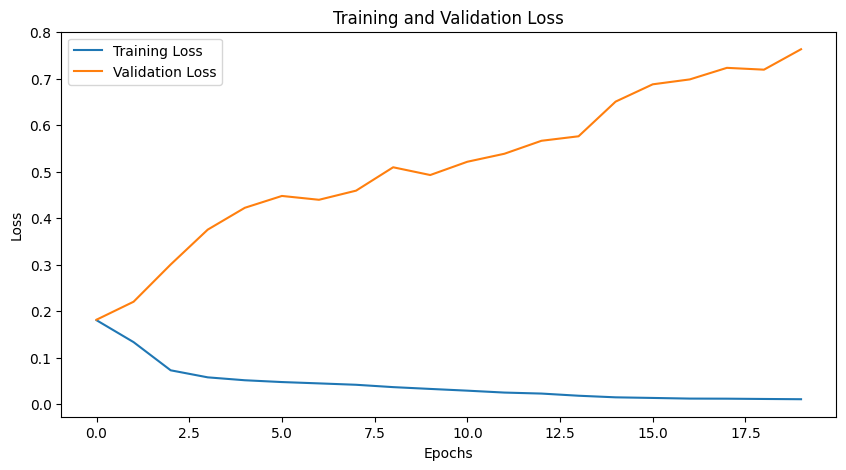

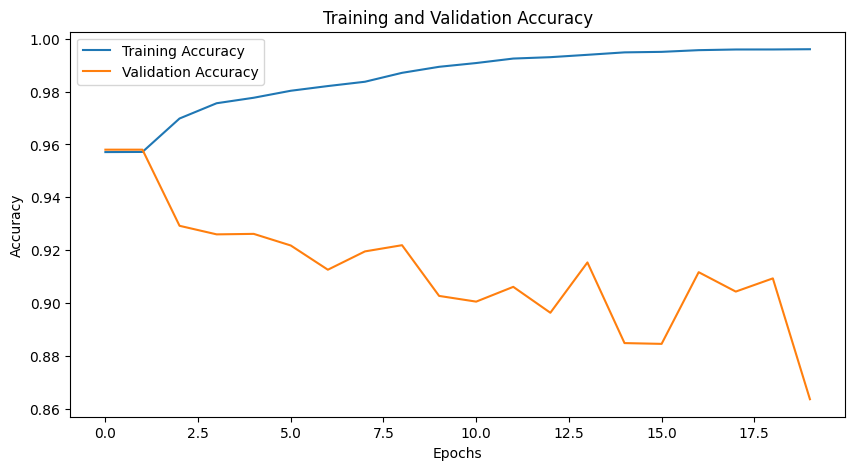

839/839 [==============================] - 2s 2ms/step - loss: 0.7635 - accuracy: 0.8636
Validation Accuracy: 0.8635991215705872
839/839 [==============================] - 2s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     25713
           1       0.04      0.10      0.06      1127

    accuracy                           0.86     26840
   macro avg       0.50      0.50      0.49     26840
weighted avg       0.92      0.86      0.89     26840



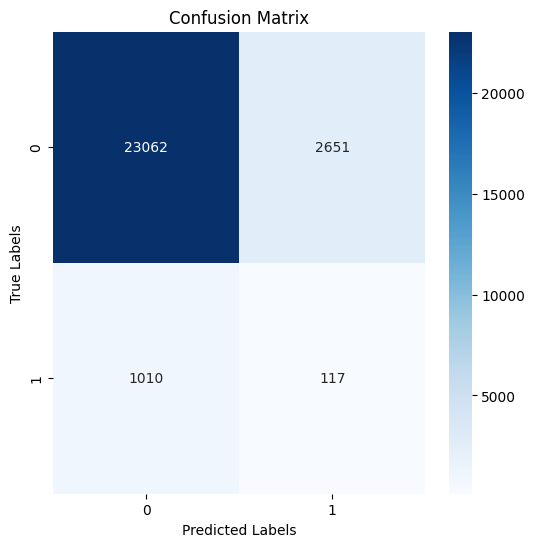

Tweet: Michigan republicans Convassers refused certify el... Label: 0
Tweet: Michigan refused certify election hundreds thousan... Label: 0
Tweet: Wow Michigan refused certify election results cour... Label: 0
Tweet: oops freezingcoldtakes RT realDonaldTrump Wow Mich... Label: 0
Tweet: BREAKING Republican election official REFUSED cert... Label: 0
Tweet: BurgerLab12 ChrisJohnsonMD wjack76995 WhoCares0118... Label: 0
Tweet: Michigan refused certify election tomorrow... Label: 0
Tweet: Good Morning Brother us Wayne County Michigan boar... Label: 0
Tweet: Michigan refused certify election rigged... Label: 1
Tweet: LLinWood SidneyPowell1 one Lin B eliminated B4e ta... Label: 0


In [ ]:
# Libraries to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths for the dataset
BASE_PATH = "/content/drive/My Drive/Forensics/"
path_dataset = BASE_PATH + "Truth_Seeker_Model_Dataset.csv"

# Read the dataset
import pandas as pd
df = pd.read_csv(path_dataset)

# Preprocess the tweets
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalnum()]
    return " ".join(filtered_tokens)

df['processed_tweet'] = df['tweet'].apply(preprocess)

# Data preparation
y = pd.factorize(df['3_label_majority_answer'])[0]

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['processed_tweet'])
sequences = tokenizer.texts_to_sequences(df['processed_tweet'])

# Padding Sequences
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

from sklearn.model_selection import train_test_split
# Splitting data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Model definition
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#...[The initial part of your code remains unchanged]...

# Training the model
num_epochs = 20  # Reduced this for faster iteration; increase if necessary.
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), verbose=1)

# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluating the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

# Making Predictions
predictions = model.predict(X_val)
predicted_labels = [int(round(pred[0])) for pred in predictions]

# Classification metrics
print("\nClassification Report:\n", classification_report(y_val, predicted_labels))

# Confusion matrix
cm = confusion_matrix(y_val, predicted_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

results = list(zip(df['processed_tweet'][len(X_train):], predicted_labels))
for tweet, label in results[:10]:
    print(f"Tweet: {tweet[:50]}... Label: {label}")

